# CanOE Nitrate

Output from recent CanOE run provided by Hakase and Nadja. 

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean

Load ANHA12 coordinate file:

In [6]:
mesh = '/data/brogalla/ANHA12/2015/ANHA12-EXH006_y2015m01d05_gridT.nc'
m = nc.Dataset(mesh)
mdepth = m.variables['deptht']
mlons = m.variables['nav_lon']
mlats = m.variables['nav_lat']
mdepth = np.array(mdepth)
mlons = np.array(mlons)
mlats = np.array(mlats)

# Mask:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
tmask = np.array(tmask[0,:,:,:])
cond = (tmask > 0.1) 
Z_masked = np.ma.masked_where(cond, tmask) 

### Functions:

In [7]:
def load_data(year):
    folder = '/ocean/brogalla/GEOTRACES/data/bio/'
    filename = 'NAA_730h_'+str(year)+'0101_'+str(year)+'1231_ptrc_T_no3.nc'
    
    data  = nc.Dataset(folder+filename)
    NO3   = np.array(data.variables['no3'])
    depth = np.array(data.variables['deptht'])
    lat   = np.array(data.variables['nav_lat'])
    lon   = np.array(data.variables['nav_lon'])
    time  = np.array(data.variables['time_counter'])

    return lat, lon, depth, NO3

In [8]:
def interp_depths(var,CanOE_depth, mdepth,fill):
    # constant extrapolation for values outside of the range
    from scipy import interpolate
    
    interp_var = np.empty((12, 50, 400, 568))
    x = CanOE_depth
    
    for t in range(0,12):
        for i in range(0,400):
            for j in range(0,568):
                # interpolate over depths        
                y = var[t,:,i,j]
                f = interpolate.interp1d(x, y, fill_value = fill)
                interp_var[t,:,i,j] = f(mdepth)
    interp_var=np.array(interp_var)
    return interp_var

In [9]:
def interp_horizon(month, lon, lat, i_NO3, mlons=mlons, mlats=mlats):
    NO3 = np.empty((50, 2400, 1632))
    for i in range(0,50):
        NO3[i,:,:] = interp_np(lon, lat, i_NO3[month,i,:,:], mlons, mlats)
    return NO3

def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate Mn model output from Marco to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : Mn model lons/lats
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D Mn model variable
    '''
    from scipy.interpolate import griddata

    LatLonPair = (nav_lon.flatten(), nav_lat.flatten())
    var_out = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='linear')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='nearest')
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

In [10]:
def save_NO3(filename, field):
    c = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc','r')

    # Load structure from sample dataset:
    deptht = c.variables['deptht']
    BX = c.dimensions['x']
    BY = c.dimensions['y']
    
    ncd = nc.Dataset(filename, 'w', zlib=True)
    nc_tools.init_dataset_attrs(
        ncd,
        title='NO3 input field',
        notebook_name='IC',
        nc_filepath='./NO3_input.nc',
        comment='CanOE NO3 deposition field')

    ncd.createDimension('x',len(BX))
    ncd.createDimension('y',len(BY))
    ncd.createDimension('deptht', len(deptht))
    
    # variables
    NO3_var = ncd.createVariable('NO3', 'float64', ('deptht','y','x'))
    NO3_var.units = ''
    NO3_var.long_name = 'Nitrate concentration'  
    NO3_var.coordinates = 'nav_lon nav_lat deptht'
    NO3_var[:] = field
    
    nc_tools.check_dataset_attrs(ncd)
    ncd.close()
    return

In [11]:
def plot_sample(NO3, mlons=mlons, mlats=mlats):
    fig,ax = plt.subplots(figsize=(15,15))
    proj=Basemap(projection='eqdc',lat_0 = 77.5, lon_0 = -93, resolution='i', width=3.5e6, height=2.68e6)
    proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=1);

    # model:
    x, y = proj(mlons, mlats)

    # plot all together:
    CS = proj.pcolor(x, y, NO3[0,10,:,:], cmap=cmocean.cm.deep)
    CBar = plt.colorbar(CS, shrink=0.6)
    CBar.ax.tick_params(axis='y', length=0)
    CBar.set_label('Interpolated NO3', fontsize=12)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.title('ANHA12 interpolation from CanOE model output')
    return

## Run:

##### Choose year:

In [12]:
year = 2003

Load CanOE biology output:

In [13]:
lat, lon, depth, NO3 = load_data(year)

First, interpolate in depth:

In [14]:
i_NO3 = interp_depths(NO3, depth, mdepth, fill='extrapolate')
i_NO3.shape

(12, 50, 400, 568)

Then, interpolate horizontally:

Based off notebook found at: https://github.com/phaustin/numeric/blob/master/demonstrations/joblib_parallel/joblib_example.ipynb

In [15]:
def joblib_solver(interp_horizon,month,lon,lat,i_NO3):
    interp = interp_horizon(month,lon,lat,i_NO3) 
    return interp

In [16]:
months=np.arange(0,12)
joblist=[]
for month in months:
    positional_args=[interp_horizon,month,lon,lat,i_NO3]
    keyword_args={}
    joblist.append((joblib_solver,positional_args,keyword_args))

In [13]:
from joblib import Parallel
ncores=2
with Parallel(n_jobs=ncores,backend='threading') as parallel:
    results=parallel(joblist)

KeyboardInterrupt: 

In [15]:
a = np.array(results)
a.shape

(12, 50, 2400, 1632)

Check that there are no NaN values:

In [16]:
print(np.count_nonzero(np.isnan(a)))

0


Plot sample output field:

/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


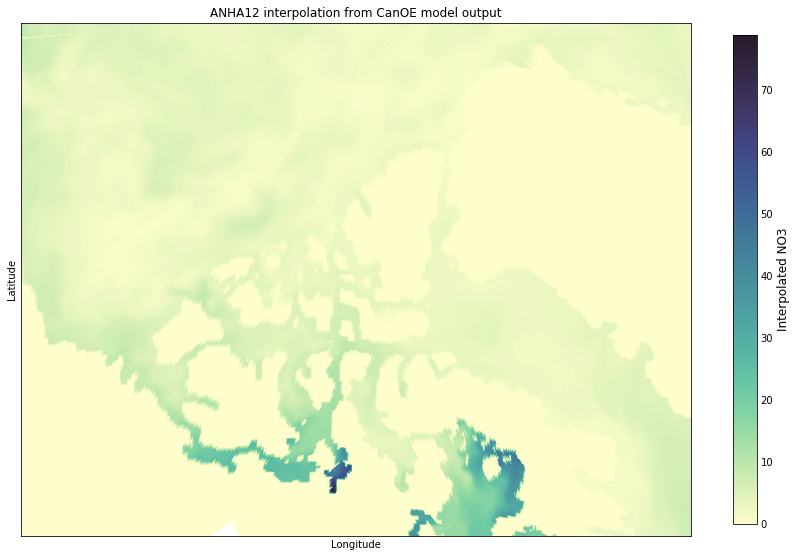

In [17]:
plot_sample(a)

save to NetCDF file:

In [18]:
for i in range(0,12):
    save_NO3('NO3_y'+str(year)+'m'+str(i+1)+'.nc',a[i,:,:,:])

file format: NETCDF4
Conventions: CF-1.6
title: NO3 input field
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/ccar-modeling/analysis-birgit/src/tip/notebooks/bio/IC.ipynb
references: REQUIRED
history: [2018-08-09 13:25:53] Created netCDF4 zlib=True dataset.
comment: CanOE NO3 deposition field
Missing value for dataset attribute: references
Missing value for variable attribute for NO3: units
file format: NETCDF4
Conventions: CF-1.6
title: NO3 input field
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/ccar-modeling/analysis-birgit/src/tip/notebooks/bio/IC.ipynb
references: REQUIRED
history: [2018-08-09 13:26:09] Created netCDF4 zlib=True dataset.
comment: CanOE NO3 deposition field
Missing value for dataset attribute: references
Missing value for variable attribute for NO3: units
file format: NETCDF4
Conventions: CF-1.6
title: NO3 input field
in

###  In case you want to look at all input fields:

In [ ]:
NO3 = i_NO3

fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot2grid((4, 3), (0, 0)) 
ax2 = plt.subplot2grid((4, 3), (0, 1)) 
ax3 = plt.subplot2grid((4, 3), (0, 2)) 
ax4 = plt.subplot2grid((4, 3), (1, 0)) 
ax5 = plt.subplot2grid((4, 3), (1, 1)) 
ax6 = plt.subplot2grid((4, 3), (1, 2)) 
ax7 = plt.subplot2grid((4, 3), (2, 0)) 
ax8 = plt.subplot2grid((4, 3), (2, 1)) 
ax9 = plt.subplot2grid((4, 3), (2, 2)) 
ax10 = plt.subplot2grid((4, 3), (3, 0)) 
ax11 = plt.subplot2grid((4, 3), (3, 1)) 
ax12 = plt.subplot2grid((4, 3), (3, 2)) 

m=Basemap(projection='eqdc',lat_0 = 77.5, lon_0 = -93, resolution='i', width=3.5e6, height=2.68e6)
x1, y1 = m(lon,lat)
x2, y2 = m(mlons, mlats)
x2 = x2[::4,::4]
y2 = y2[::4,::4]
z2 = Z_masked[0,::4,::4]

m.pcolor(x1,y1,NO3[0,0,:,:], cmap=cmocean.cm.deep, vmin=0, vmax=75, ax=ax1)
ax1.set_title('Month 1')
m.pcolor(x2,y2,z2, vmin=-1, vmax = 0.3, cmap=cmocean.cm.matter_r, ax=ax1)    
m.pcolor(x1,y1,NO3[1,0,:,:], cmap=cmocean.cm.deep, vmin=0, vmax=75, ax=ax2)
m.pcolor(x2,y2,z2, vmin=-1, vmax = 0.3, cmap=cmocean.cm.matter_r, ax=ax2)    
ax2.set_title('Month 2')
d=m.pcolor(x1,y1,NO3[2,0,:,:], cmap=cmocean.cm.deep, vmin=0, vmax=75, ax=ax3)
m.pcolor(x2,y2,z2, vmin=-1, vmax = 0.3, cmap=cmocean.cm.matter_r, ax=ax3) 
ax3.set_title('Month 3')
cbaxes = fig.add_axes([0.975, 0.15, 0.02, 0.7]) 
CBar = plt.colorbar(d, ax=ax3, cax=cbaxes) 
a = CBar.set_label('NO3', fontsize=16)
CBar.ax.tick_params(axis='y', length=0, labelsize=16)

m.pcolor(x1,y1,NO3[3,0,:,:], cmap=cmocean.cm.deep, vmin=0, vmax=75, ax=ax4)
m.pcolor(x2,y2,z2, vmin=-1, vmax = 0.3, cmap=cmocean.cm.matter_r, ax=ax4) 
ax4.set_title('Month 4')
m.pcolor(x1,y1,NO3[4,0,:,:], cmap=cmocean.cm.deep, vmin=0, vmax=75, ax=ax5)
m.pcolor(x2,y2,z2, vmin=-1, vmax = 0.3, cmap=cmocean.cm.matter_r, ax=ax5) 
ax5.set_title('Month 5')
m.pcolor(x1,y1,NO3[5,0,:,:], cmap=cmocean.cm.deep, vmin=0, vmax=75, ax=ax6)
m.pcolor(x2,y2,z2, vmin=-1, vmax = 0.3, cmap=cmocean.cm.matter_r, ax=ax6) 
ax6.set_title('Month 6')
m.pcolor(x1,y1,NO3[6,0,:,:], cmap=cmocean.cm.deep, vmin=0, vmax=75, ax=ax7)
m.pcolor(x2,y2,z2, vmin=-1, vmax = 0.3, cmap=cmocean.cm.matter_r, ax=ax7) 
ax7.set_title('Month 7')
m.pcolor(x1,y1,NO3[7,0,:,:], cmap=cmocean.cm.deep, vmin=0, vmax=75, ax=ax8)
m.pcolor(x2,y2,z2, vmin=-1, vmax = 0.3, cmap=cmocean.cm.matter_r, ax=ax8) 
ax8.set_title('Month 8')
m.pcolor(x1,y1,NO3[8,0,:,:], cmap=cmocean.cm.deep, vmin=0, vmax=75, ax=ax9)
m.pcolor(x2,y2,z2, vmin=-1, vmax = 0.3, cmap=cmocean.cm.matter_r, ax=ax9) 
ax9.set_title('Month 9')
m.pcolor(x1,y1,NO3[9,0,:,:], cmap=cmocean.cm.deep, vmin=0, vmax=75, ax=ax10)
m.pcolor(x2,y2,z2, vmin=-1, vmax = 0.3, cmap=cmocean.cm.matter_r, ax=ax10) 
ax10.set_title('Month 10')
m.pcolor(x1,y1,NO3[10,0,:,:], cmap=cmocean.cm.deep, vmin=0, vmax=75, ax=ax11)
m.pcolor(x2,y2,z2, vmin=-1, vmax = 0.3, cmap=cmocean.cm.matter_r, ax=ax11) 
ax11.set_title('Month 11')
m.pcolor(x1,y1,NO3[11,0,:,:], cmap=cmocean.cm.deep, vmin=0, vmax=75, ax=ax12)
m.pcolor(x2,y2,z2, vmin=-1, vmax = 0.3, cmap=cmocean.cm.matter_r, ax=ax12) 
ax12.set_title('Month 12')